In [1]:
from utils import base_configs, deps, tr_va_te_split
from utils import tr_va_te_split
from utils.helpers import dir_helpers, rw_csv_helpers, feature_distr_helpers, feature_transform_helpers

/home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys, math
import import_ipynb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 0 Data load

In [3]:
df_hints6 = "ip/3_cleanedEncoded/hints6_public_filtered_v1_cleaned_encoded.csv"
df_hints7 = "ip/3_cleanedEncoded/....csv"
df_hints6_7 = "ip/3_cleanedEncoded/hints6_7_cleaned_encoded.csv"
df_orig = rw_csv_helpers.read_csv_file(df_hints6, verbose = 1)

Loaded: /home/ppanta/puru_proj/proj_v0/hints6_v0/ip/3_cleanedEncoded/hints6_public_filtered_v1_cleaned_encoded.csv
────────────────────────────────────────────────────────────────────────────────
Shape: (4865, 27)
────────────────────────────────────────────────────────────────────────────────
All columns: ['FreqGoProvider', 'Deaf', 'MedConditions_Diabetes', 'MedConditions_HighBP', 'MedConditions_HeartCondition', 'MedConditions_LungDisease', 'MedConditions_Depression', 'AverageSleepNight', 'AverageTimeSitting', 'EverHadCancer', 'Age', 'BirthGender', 'BMI', 'PHQ4', 'WeeklyMinutesModerateExercise', 'AvgDrinksPerWeek', 'GeneralHealth_Excellent', 'GeneralHealth_VeryGood', 'GeneralHealth_Good', 'GeneralHealth_Fair', 'GeneralHealth_Poor', 'smokeStat_Current', 'smokeStat_Former', 'smokeStat_Never', 'eCigUse_Current', 'eCigUse_Former', 'eCigUse_Never']


In [4]:
counts = feature_distr_helpers.count01(df_orig.copy(), "MedConditions_HeartCondition", verbose=1)

Counts for column 'MedConditions_HeartCondition' (only 0 and 1):
MedConditions_HeartCondition
0    4412
1     453
Name: count, dtype: int64
Total (0/1 only): 4865


### 1 Train - Validation - Test split

In [5]:
df_orig = df_orig.copy()
target_col = "MedConditions_HeartCondition"
CONFIGS = base_configs.get_base_configs()

X = df_orig.drop(columns=[target_col])
y = df_orig[target_col]

result = tr_va_te_split.data_preprocessing(
    CONFIGS=CONFIGS,
    verbose=0,       # 0, 1, or 2
    X=X, y=y,
    balance_method="adasyn",  # or 'smote', 'smoteenn', 'none'
    balance_kwargs={"n_neighbors": 5}  # optional
)

### 2 Train - Validation - Test value assignments

In [6]:
# Value assignments for further calculations
X_train_res_scaled = result['X_train_res_scaled']
X_val_scaled       = result['X_val_scaled']
X_test_scaled      = result['X_test_scaled']

X_train     = result['X_train']
X_train_res = result['X_train_res']
X_val       = result['X_val']
X_test      = result['X_test']

y_train     = result['y_train']
y_train_res = result['y_train_res']
y_val       = result['y_val']
y_test      = result['y_test']

features    = result['features']


### 3 Train - Validation - Test split export csv files

In [7]:
import os
from datetime import datetime
import pandas as pd

def make_timestamped_outdir(base="op/1_data_explore3/exports_preproc_dataset",
                            fmt="%Y%m%d_%H%M%S"):
    """Return an ensured directory like '..._20250929_141530'."""
    stamp = datetime.now().strftime(fmt)
    outdir = f"{base}_{stamp}"
    os.makedirs(outdir, exist_ok=True)
    return outdir

def export_preproc_csvs(result: dict, target_col: str, outdir: str, prefix: str = "preproc", include_index: bool = False):
    """
    Save:
      - X_train + y_train
      - X_train_res (balanced) + y_train_res
      - X_train_res_scaled (balanced+scaled) + y_train_res
      - X_val + y_val
      - X_test + y_test
    to individual CSV files under `outdir`.
    """
    os.makedirs(outdir, exist_ok=True)

    # Ensure y names
    for key in ["y_train", "y_train_res", "y_val", "y_test"]:
        if result[key].name is None:
            result[key] = result[key].rename(target_col)

    def _join_xy(X, y):
        return pd.concat([X, y], axis=1)

    files = {
        "train":             (result["X_train"],             result["y_train"],             f"{prefix}_train.csv"),
        "train_balanced":    (result["X_train_res"],         result["y_train_res"],         f"{prefix}_train_balanced.csv"),
        "train_bal_scaled":  (result["X_train_res_scaled"],  result["y_train_res"],         f"{prefix}_train_bal_scaled.csv"),
        "val":               (result["X_val"],               result["y_val"],               f"{prefix}_val.csv"),
        "test":              (result["X_test"],              result["y_test"],              f"{prefix}_test.csv"),
    }

    paths = {}
    for tag, (X, y, fname) in files.items():
        path = os.path.join(outdir, fname)
        _join_xy(X, y).to_csv(path, index=include_index)
        paths[tag] = path
    return paths


In [8]:
outdir = make_timestamped_outdir("op/1_data_explore3/exports_preproc_dataset")
paths = export_preproc_csvs(
    result,
    target_col="MedConditions_HeartCondition",
    outdir=outdir,
    prefix="preproc",
    include_index=False
)
print("Saved to:", outdir)
for k, v in paths.items():
    print(f"{k:16} -> {v}")


Saved to: op/1_data_explore3/exports_preproc_dataset_20251130_195143
train            -> op/1_data_explore3/exports_preproc_dataset_20251130_195143/preproc_train.csv
train_balanced   -> op/1_data_explore3/exports_preproc_dataset_20251130_195143/preproc_train_balanced.csv
train_bal_scaled -> op/1_data_explore3/exports_preproc_dataset_20251130_195143/preproc_train_bal_scaled.csv
val              -> op/1_data_explore3/exports_preproc_dataset_20251130_195143/preproc_val.csv
test             -> op/1_data_explore3/exports_preproc_dataset_20251130_195143/preproc_test.csv


### 4 Train - Validation - Test split tabular display

In [9]:
import pandas as pd
from IPython.display import display, HTML

# ----------------------------
# Helpers to build the tables
# ----------------------------
def _dist01(y: pd.Series):
    """Return dict for 0/1 counts & pct; missing classes shown as 0."""
    vc = y.value_counts(dropna=False)
    n = len(y)
    c0 = int(vc.get(0, 0)); p0 = round(c0 / n * 100, 2) if n else 0.0
    c1 = int(vc.get(1, 0)); p1 = round(c1 / n * 100, 2) if n else 0.0
    return dict(
        y_len=n,
        class0_count=c0, class0_pct=p0,
        class1_count=c1, class1_pct=p1
    )

def _row(label: str, X: pd.DataFrame, y: pd.Series):
    d = _dist01(y)
    return dict(
        Stage=label,
        X_rows=X.shape[0], X_cols=X.shape[1],
        y_len=d["y_len"],
        class0_count=d["class0_count"], class0_pct=d["class0_pct"],
        class1_count=d["class1_count"], class1_pct=d["class1_pct"],
    )

def make_preproc_tables(result: dict) -> dict[str, pd.DataFrame]:
    """
    Build 4 tables (Original, Split, Balanced, Scaled) from the dict returned by data_preprocessing().
    """
    # Reconstruct original from splits
    X_all = pd.concat([result["X_train"], result["X_val"], result["X_test"]], axis=0)
    y_all = pd.concat([result["y_train"], result["y_val"], result["y_test"]], axis=0)

    tbl_original = pd.DataFrame([_row("Complete dataset", X_all, y_all)])

    tbl_split = pd.DataFrame([
        _row("Train",      result["X_train"], result["y_train"]),
        _row("Validation", result["X_val"],   result["y_val"]),
        _row("Test",       result["X_test"],  result["y_test"]),
    ])

    tbl_balanced = pd.DataFrame([
        _row("Train",      result["X_train_res"], result["y_train_res"]),
        _row("Validation", result["X_val"],       result["y_val"]),
        _row("Test",       result["X_test"],      result["y_test"]),
    ])

    tbl_scaled = pd.DataFrame([
        _row("Train",      result["X_train_res_scaled"], result["y_train_res"]),
        _row("Validation", result["X_val_scaled"],       result["y_val"]),
        _row("Test",       result["X_test_scaled"],      result["y_test"]),
    ])

    cols = ["Stage", "X_rows", "X_cols", "y_len",
            "class0_count", "class0_pct", "class1_count", "class1_pct"]
    return {
        "original": tbl_original[cols],
        "split":    tbl_split[cols],
        "balanced": tbl_balanced[cols],
        "scaled":   tbl_scaled[cols],
    }


In [10]:
# ----------------------------
# Build tables from your result
# ----------------------------
result = tr_va_te_split.data_preprocessing(CONFIGS=CONFIGS, verbose=0, X=X, y=y, balance_method="adasyn")
tables = make_preproc_tables(result)

# ----------------------------
# Dynamic captions/headers
# ----------------------------
orig_total = int(tables["original"]["y_len"].iloc[0])

# Split sizes
train_n = int(tables["split"].loc[tables["split"]["Stage"]=="Train", "y_len"].iloc[0])
val_n   = int(tables["split"].loc[tables["split"]["Stage"]=="Validation", "y_len"].iloc[0])
test_n  = int(tables["split"].loc[tables["split"]["Stage"]=="Test", "y_len"].iloc[0])

p_train_split = round(train_n / orig_total * 100, 2) if orig_total else 0.0
p_val_split   = round(val_n   / orig_total * 100, 2) if orig_total else 0.0
p_test_split  = round(test_n  / orig_total * 100, 2) if orig_total else 0.0

# Balanced (train after ADASYN)
train_res_n = int(tables["balanced"].loc[tables["balanced"]["Stage"]=="Train", "y_len"].iloc[0])
balanced_total = train_res_n + val_n + test_n

p_train_bal = round(train_res_n / balanced_total * 100, 2) if balanced_total else 0.0
p_val_bal   = round(val_n       / balanced_total * 100, 2) if balanced_total else 0.0
p_test_bal  = round(test_n      / balanced_total * 100, 2) if balanced_total else 0.0

# Captions
cap1 = "Complete dataset"

cap2 = (
    "Train-Validation-Test split:\n"
    f"Train = {train_n} ({p_train_split:.2f}%) + "
    f"Validation = {val_n} ({p_val_split:.2f}%) + "
    f"Test = {test_n} ({p_test_split:.2f}%)"
)

cap3 = (
    "Balancing train dataset:\n"
    f"Train = {train_n} ({p_train_split:.2f}%) to "
    f"{train_res_n} ({p_train_bal:.2f}% scaled up) + "
    f"Validation = {val_n} ({p_val_bal:.2f}%) + "
    f"Test = {test_n} ({p_test_bal:.2f}%)"
)

cap4 = (
    "Scaling train dataset:\n"
    f"Train = {train_n} ({p_train_split:.2f}%) to "
    f"{train_res_n} ({p_train_bal:.2f}% scaled up) + "
    f"Validation = {val_n} ({p_val_bal:.2f}%) + "
    f"Test = {test_n} ({p_test_bal:.2f}%)"
)


In [11]:
# ----------------------------
# Display with headers + separators (no .style)
# ----------------------------
fmt = {"class0_pct":"{:.2f}%", "class1_pct":"{:.2f}%"}

feature_transform_helpers.show_table(tables["original"], caption=cap1, fmt=fmt)
display(HTML("<div style='margin:10px 0;border-top:2px solid #888;'></div>"))

feature_transform_helpers.show_table(tables["split"], caption=cap2, fmt=fmt)
display(HTML("<div style='margin:10px 0;border-top:2px solid #888;'></div>"))

feature_transform_helpers.show_table(tables["balanced"], caption=cap3, fmt=fmt)
display(HTML("<div style='margin:10px 0;border-top:2px solid #888;'></div>"))

feature_transform_helpers.show_table(tables["scaled"], caption=cap4, fmt=fmt)

,Stage,X_rows,X_cols,y_len,class0_count,class0_pct,class1_count,class1_pct
0,Complete dataset,4865,26,4865,4412,90.69%,453,9.31%


,Stage,X_rows,X_cols,y_len,class0_count,class0_pct,class1_count,class1_pct
0,Train,2919,26,2919,2647,90.68%,272,9.32%
1,Validation,973,26,973,882,90.65%,91,9.35%
2,Test,973,26,973,883,90.75%,90,9.25%


,Stage,X_rows,X_cols,y_len,class0_count,class0_pct,class1_count,class1_pct
0,Train,5271,26,5271,2647,50.22%,2624,49.78%
1,Validation,973,26,973,882,90.65%,91,9.35%
2,Test,973,26,973,883,90.75%,90,9.25%


,Stage,X_rows,X_cols,y_len,class0_count,class0_pct,class1_count,class1_pct
0,Train,5271,26,5271,2647,50.22%,2624,49.78%
1,Validation,973,26,973,882,90.65%,91,9.35%
2,Test,973,26,973,883,90.75%,90,9.25%


### 5 Train - Validation - Test export to csv

In [12]:
def save_tables_to_csv(tables, outdir="exports_preproc", prefix="preproc"):
    paths = {}
    # 1) individual CSVs
    for name, df in tables.items():
        path = os.path.join(outdir, f"{prefix}_{name}.csv")
        df.to_csv(path, index=False)
        paths[name] = path

    # 2) optional combined CSV (all stages together)
    combined = pd.concat([
        tables["original"].assign(Block="1) Original"),
        tables["split"].assign(Block="2) After Split"),
        tables["balanced"].assign(Block="3) After Balance"),
        tables["scaled"].assign(Block="4) After Scale"),
    ], ignore_index=True)[[
        "Block","Stage","X_rows","X_cols","y_len",
        "class0_count","class0_pct","class1_count","class1_pct"
    ]]

    combined_path = os.path.join(outdir, f"{prefix}_combined.csv")
    combined.to_csv(combined_path, index=False)
    paths["combined"] = combined_path

    return paths


In [13]:
import os
# Choose an output folder and filename prefix
outdir = "op/1_data_explore3"
prefix = "preproc"
os.makedirs(outdir, exist_ok=True)

paths = save_tables_to_csv(tables, outdir=outdir, prefix=prefix)
for k, v in paths.items():
    print(f"{k:9} -> {v}")


original  -> op/1_data_explore3/preproc_original.csv
split     -> op/1_data_explore3/preproc_split.csv
balanced  -> op/1_data_explore3/preproc_balanced.csv
scaled    -> op/1_data_explore3/preproc_scaled.csv
combined  -> op/1_data_explore3/preproc_combined.csv


### 6 Train - Validation - Test split plot display

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def _build_data_split_and_class_fig(
    tables,
    title="Data Split & Class Distribution",
    total_fmt="{:,}",
    total_offset=0.02
):
    """
    Internal: builds the figure and returns (fig, ax) without showing or saving.
    """
    # ---------- pull numbers ----------
    split = tables["split"]
    n_train = int(split.query("Stage=='Train'")["y_len"].iloc[0])
    n_val   = int(split.query("Stage=='Validation'")["y_len"].iloc[0])
    n_test  = int(split.query("Stage=='Test'")["y_len"].iloc[0])

    original = tables["original"].iloc[0]
    full_c0, full_c1 = int(original["class0_count"]), int(original["class1_count"])

    tr_raw_c0 = int(split.query("Stage=='Train'")["class0_count"].iloc[0])
    tr_raw_c1 = int(split.query("Stage=='Train'")["class1_count"].iloc[0])

    bal = tables["balanced"]
    tr_bal_c0 = int(bal.query("Stage=='Train'")["class0_count"].iloc[0])
    tr_bal_c1 = int(bal.query("Stage=='Train'")["class1_count"].iloc[0])

    val_c0 = int(split.query("Stage=='Validation'")["class0_count"].iloc[0])
    val_c1 = int(split.query("Stage=='Validation'")["class1_count"].iloc[0])
    te_c0  = int(split.query("Stage=='Test'")["class0_count"].iloc[0])
    te_c1  = int(split.query("Stage=='Test'")["class1_count"].iloc[0])

    labels = ["Split Sizes","Full Class Dist","Train (raw)","Train (ADASYN)","Validation","Test"]
    x = np.arange(len(labels)); width = 0.75

    # colors
    c_train, c_val, c_test = "#19d3d3", "#ffa600", "#e3a74f"
    c_c0, c_c1 = "#1f77b4", "#2ca02c"

    # totals per bar (for label placement & ylim)
    totals = [
        n_train + n_val + n_test,
        full_c0 + full_c1,
        tr_raw_c0 + tr_raw_c1,
        tr_bal_c0 + tr_bal_c1,
        val_c0 + val_c1,
        te_c0 + te_c1,
    ]
    ymax = max(totals)
    ypad = ymax * total_offset

    fig, ax = plt.subplots(figsize=(12, 6))

    # --- Bar 1: split sizes ---
    ax.bar(x[0], n_train, width=width, color=c_train, label="Train")
    ax.bar(x[0], n_val,   width=width, bottom=n_train,           color=c_val,  label="Validation")
    ax.bar(x[0], n_test,  width=width, bottom=n_train+n_val,     color=c_test, label="Test")

    # --- Bar 2: full class dist ---
    ax.bar(x[1], full_c0, width=width, color=c_c0, label="Class 0")
    ax.bar(x[1], full_c1, width=width, bottom=full_c0, color=c_c1, label="Class 1")

    # --- Bars 3–6: class stacks ---
    stacks = [
        (x[2], tr_raw_c0, tr_raw_c1),
        (x[3], tr_bal_c0, tr_bal_c1),
        (x[4], val_c0,    val_c1),
        (x[5], te_c0,     te_c1),
    ]
    for xi, c0, c1 in stacks:
        ax.bar(xi, c0, width=width, color=c_c0)
        ax.bar(xi, c1, width=width, bottom=c0, color=c_c1)

    # ----- annotations (segment + total) -----
    def annotate_inside(xpos, bottom, height, txt):
        if height > 0:
            ax.text(xpos, bottom + height/2, txt, ha="center", va="center", fontsize=9)

    def annotate_total(xpos, total):
        ax.text(xpos, total + ypad, total_fmt.format(total), ha="center", va="bottom", fontsize=10, fontweight="bold")

    # Bar 1 segments + total
    annotate_inside(x[0], 0, n_train, f"{n_train}")
    annotate_inside(x[0], n_train, n_val, f"{n_val}")
    annotate_inside(x[0], n_train+n_val, n_test, f"{n_test}")
    annotate_total(x[0], totals[0])

    # Bar 2 segments + total
    annotate_inside(x[1], 0, full_c0, f"{full_c0}")
    annotate_inside(x[1], full_c0, full_c1, f"{full_c1}")
    annotate_total(x[1], totals[1])

    # Bars 3–6
    for i, (xi, c0, c1) in enumerate(stacks, start=2):
        annotate_inside(xi, 0, c0, f"{c0}")
        annotate_inside(xi, c0, c1, f"{c1}")
        annotate_total(xi, totals[i])

    # cosmetics
    ax.set_ylim(0, ymax + 3*ypad)
    ax.set_title(title)
    ax.set_ylabel("Sample count")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    legend_handles = [
        plt.Rectangle((0,0),1,1,color=c_train),
        plt.Rectangle((0,0),1,1,color=c_val),
        plt.Rectangle((0,0),1,1,color=c_test),
        plt.Rectangle((0,0),1,1,color=c_c0),
        plt.Rectangle((0,0),1,1,color=c_c1),
    ]
    ax.legend(legend_handles, ["Train","Validation","Test","Class 0","Class 1"],
              title="Class / Split", loc="upper right")

    fig.tight_layout()
    return fig, ax


def show_data_split_and_class_dist(
    tables,
    title="Data Split & Class Distribution",
    total_fmt="{:,}",
    total_offset=0.02
):
    """Build and display the plot."""
    fig, ax = _build_data_split_and_class_fig(
        tables, title=title, total_fmt=total_fmt, total_offset=total_offset
    )
    plt.show()
    return fig, ax  # handy if you want to tweak after showing


def save_data_split_and_class_dist(
    tables,
    filepath,
    title="Data Split & Class Distribution",
    total_fmt="{:,}",
    total_offset=0.02,
    dpi=200
):
    """Build and save the plot to `filepath` (does not display)."""
    fig, ax = _build_data_split_and_class_fig(
        tables, title=title, total_fmt=total_fmt, total_offset=total_offset
    )
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    return filepath


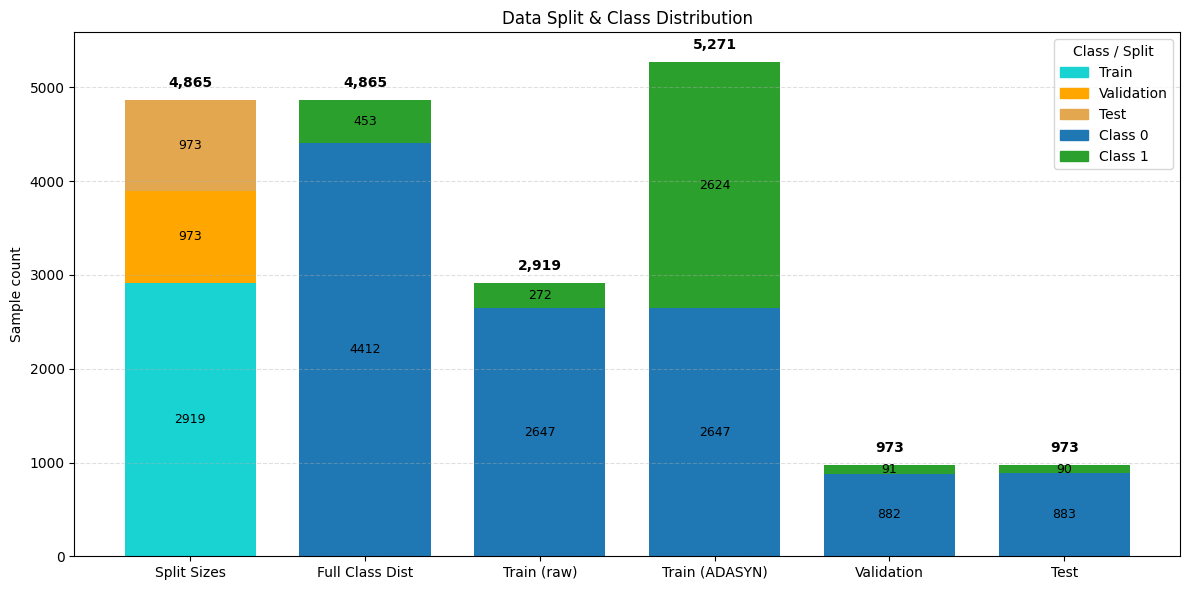

In [15]:
# Show in notebook
fig, ax = show_data_split_and_class_dist(tables)

# Save to file (PNG/PDF/SVG, etc.)
filepath = save_data_split_and_class_dist(tables, "op/1_data_explore3/data_split_class_distribution.png")
